In [1]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from sklearn import metrics, preprocessing
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils
#Load the data and make new df
target = pd.read_csv("input/train.csv").target

In [2]:
os.listdir('embs')

['test_emb50.npy',
 'train_emb100.npy',
 'tanh_train_emb50.npy',
 'train_emb50.npy',
 'train_emb10.npy',
 'tanh_test_emb10.npy',
 'sig_train_emb5.npy',
 'tanh_train_emb20.npy',
 'test_emb10.npy',
 'test_emb100.npy',
 'test_emb20.npy',
 'tanh_test_emb20.npy',
 'sig_train_emb10.npy',
 'train_emb5.npy',
 'sig_test_emb20.npy',
 'tanh_test_emb100.npy',
 'tanh_test_emb50.npy',
 'sig_test_emb10.npy',
 'tanh_train_emb10.npy',
 'sig_train_emb20.npy',
 'tanh_train_emb5.npy',
 'tanh_test_emb5.npy',
 'sig_test_emb5.npy',
 'test_emb5.npy',
 'train_emb20.npy',
 'tanh_train_emb100.npy']

In [3]:
def get_tuned_xgb(x,y): 
    # A parameter grid for XGBoost
    params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'n_estimators' : [50, 100, 200, 300, 500, 800, 1000]
        }
    
    xgb = XGBClassifier(objective='binary:logistic', n_jobs=10)

    folds = 5
    param_comb = 15
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1003)
    random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', cv=skf.split(x,y), verbose=2, random_state=1003 )

    random_search.fit(x,y)
    print(random_search.best_score_)
    return XGBClassifier(**random_search.best_params_), random_search.best_score_
 
    


def get_tuned_lgbm(x,y): 
    # A parameter grid for XGBoost
    params = {'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}
    
    lg = LGBMClassifier(objective='binary')

    folds = 5
    param_comb = 15
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1002)
    random_search = RandomizedSearchCV(lg, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=10, cv=skf.split(x,y), verbose=0, random_state=1002 )

    random_search.fit(x,y)
    print(random_search.best_score_)
    return LGBMClassifier(**random_search.best_params_), random_search.best_score_




def get_tuned_cat(x,y): 
    # A parameter grid for XGBoost
    params = {'depth':[3,1,2,6,4,5,7,8,9,10],
          'iterations':[2,50,100,500,1000],
          'learning_rate':[0.03,0.001,0.01,0.1,0.2,0.3], 
          'l2_leaf_reg':[3,1,5,10,100],
          'border_count':[32,5,10,20,50,100,200],
          'thread_count':[4],
              'loss_function': ['Logloss', 'CrossEntropy']}
    
    cat = CatBoostClassifier(eval_metric = 'AUC')

    folds = 5
    param_comb = 15
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
    random_search = RandomizedSearchCV(cat, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=10, cv=skf.split(x,y), verbose=0, random_state=1001 )

    random_search.fit(x,y)
    print(random_search.best_score_)
    return CatBoostClassifier(**random_search.best_params_), random_search.best_score_


def auc(y_true, y_pred):
    def fallback_auc(y_true, y_pred):
        try:
            return metrics.roc_auc_score(y_true, y_pred)
        except:
            return 0.5
    return tf.py_function(fallback_auc, (y_true, y_pred), tf.double)


def get_nn(n_dim):
    model = Sequential()
    model.add(layers.Input(shape= (n_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.3))
    model.add(Dense(1,activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])
    return model



def get_tuned_lr(x,y): 
    penalty = ['l1', 'l2']
    C = np.logspace(0, 4, 10)
    solver=['liblinear']
    params = dict(C=C, penalty=penalty, solver=solver)
    
    lr = LogisticRegression( )

    folds = 5
    param_comb = 15
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
    random_search = RandomizedSearchCV(lr, param_distributions=params, n_jobs=10, n_iter=param_comb, scoring='roc_auc', cv=skf.split(x,y), verbose=0, random_state=1001 )

    random_search.fit(x,y)
    print(random_search.best_score_)
    return LogisticRegression(**random_search.best_params_), random_search.best_score_




   
    

In [4]:
preds = []
cvs = []
model_fs = [get_tuned_lr,get_tuned_xgb,get_tuned_cat,get_tuned_lgbm]
embs_dims = [100,50,20,10,5]
for emb_dim in tqdm(embs_dims):
    train = pd.DataFrame(np.load('embs/tanh_train_emb'+str(emb_dim)+'.npy'))
    test = pd.DataFrame(np.load('embs/tanh_test_emb'+str(emb_dim)+'.npy'))
    for f in model_fs:
        model, cv = f(train,target)
        cvs.append(cv)
        model.fit(train,target)
        preds.append(model.predict_proba(test))
                     
    oof_preds = np.zeros((len(train)))
    test_preds = np.zeros((len(test)))
    temp_cvs = []          
    skf = StratifiedKFold(n_splits=20)
    for train_index, test_index in skf.split(train, target):
   
        model = get_nn(emb_dim)

        es = callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=5,
                                     verbose=1, mode='max', baseline=None, restore_best_weights=True)

        rlr = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                                          patience=3, min_lr=1e-6, mode='max', verbose=1)
        X_train, X_test = train.iloc[train_index, :], train.iloc[test_index, :]
        X_train = X_train.reset_index(drop=True)
        X_test = X_test.reset_index(drop=True)
        y_train, y_test = target[train_index], target[test_index]
        model = get_nn(emb_dim)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])
        
        es = callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=5,
                                     verbose=1, mode='max', baseline=None, restore_best_weights=True)

        rlr = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                                          patience=3, min_lr=1e-6, mode='max', verbose=1)

        model.fit(X_train,y_train,
                  validation_data=(X_test, y_test),
                  verbose=1,
                  batch_size=1024,
                  callbacks=[es, rlr],
                  epochs=100
                 )
        valid_fold_preds = model.predict(X_test)
        test_fold_preds = model.predict(test)
        oof_preds[test_index] = valid_fold_preds.ravel()
        test_preds += test_fold_preds.ravel()
        temp_cvs.append(metrics.roc_auc_score(y_test, valid_fold_preds))
        
        K.clear_session()
    preds.append(np.array(test_preds)/20)
    cvs.append(sum(temp_cvs)/len(temp_cvs))
    print(cvs[-1])
    

  0%|          | 0/5 [00:00<?, ?it/s]

0.840738721623152
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total= 2.2min
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.2min remaining:    0.0s


[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total= 2.4min
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total= 2.3min
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total= 2.3min
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total= 2.3min
[CV] subsample=0.6, n_estimators=50, min_child_weight=10, max_depth=3, gamma=0.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=50, min_child_weight=10, max_depth=3, gamma=0.5, colsample_bytree=1.0, total=   9

[CV]  subsample=1.0, n_estimators=100, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6, total=  22.0s
[CV] subsample=1.0, n_estimators=100, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6 
[CV]  subsample=1.0, n_estimators=100, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6, total=  22.0s
[CV] subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0, total= 1.3min
[CV] subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0, total= 1.3min
[CV] subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0, total=

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 90.6min finished


0.8465255523325426


/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0:	total: 167ms	remaining: 1m 23s
1:	total: 279ms	remaining: 1m 9s
2:	total: 405ms	remaining: 1m 7s
3:	total: 537ms	remaining: 1m 6s
4:	total: 671ms	remaining: 1m 6s
5:	total: 803ms	remaining: 1m 6s
6:	total: 927ms	remaining: 1m 5s
7:	total: 1.04s	remaining: 1m 3s
8:	total: 1.15s	remaining: 1m 2s
9:	total: 1.27s	remaining: 1m 2s
10:	total: 1.39s	remaining: 1m 1s
11:	total: 1.52s	remaining: 1m 1s
12:	total: 1.64s	remaining: 1m 1s
13:	total: 1.76s	remaining: 1m 1s
14:	total: 1.9s	remaining: 1m 1s
15:	total: 2.02s	remaining: 1m 1s
16:	total: 2.14s	remaining: 1m
17:	total: 2.25s	remaining: 1m
18:	total: 2.38s	remaining: 1m
19:	total: 2.49s	remaining: 59.8s
20:	total: 2.62s	remaining: 59.8s
21:	total: 2.74s	remaining: 59.6s
22:	total: 2.87s	remaining: 59.6s
23:	total: 3s	remaining: 59.5s
24:	total: 3.13s	remaining: 59.5s
25:	total: 3.23s	remaining: 59s
26:	total: 3.36s	remaining: 58.8s
27:	total: 3.48s	remaining: 58.8s
28:	total: 3.62s	remaining: 58.7s
29:	total: 3.72s	remaining: 58.4s
30:	

241:	total: 25.8s	remaining: 27.5s
242:	total: 25.9s	remaining: 27.4s
243:	total: 26s	remaining: 27.3s
244:	total: 26.1s	remaining: 27.2s
245:	total: 26.2s	remaining: 27s
246:	total: 26.3s	remaining: 26.9s
247:	total: 26.4s	remaining: 26.8s
248:	total: 26.5s	remaining: 26.7s
249:	total: 26.6s	remaining: 26.6s
250:	total: 26.7s	remaining: 26.5s
251:	total: 26.8s	remaining: 26.4s
252:	total: 26.9s	remaining: 26.3s
253:	total: 27s	remaining: 26.2s
254:	total: 27.1s	remaining: 26s
255:	total: 27.2s	remaining: 25.9s
256:	total: 27.3s	remaining: 25.8s
257:	total: 27.4s	remaining: 25.7s
258:	total: 27.5s	remaining: 25.6s
259:	total: 27.6s	remaining: 25.5s
260:	total: 27.7s	remaining: 25.4s
261:	total: 27.8s	remaining: 25.3s
262:	total: 27.9s	remaining: 25.2s
263:	total: 28s	remaining: 25s
264:	total: 28.1s	remaining: 24.9s
265:	total: 28.2s	remaining: 24.8s
266:	total: 28.3s	remaining: 24.7s
267:	total: 28.4s	remaining: 24.6s
268:	total: 28.5s	remaining: 24.5s
269:	total: 28.6s	remaining: 24.

478:	total: 50.1s	remaining: 2.19s
479:	total: 50.2s	remaining: 2.09s
480:	total: 50.3s	remaining: 1.99s
481:	total: 50.4s	remaining: 1.88s
482:	total: 50.5s	remaining: 1.78s
483:	total: 50.6s	remaining: 1.67s
484:	total: 50.7s	remaining: 1.57s
485:	total: 50.8s	remaining: 1.46s
486:	total: 50.9s	remaining: 1.36s
487:	total: 51s	remaining: 1.25s
488:	total: 51.1s	remaining: 1.15s
489:	total: 51.2s	remaining: 1.04s
490:	total: 51.3s	remaining: 940ms
491:	total: 51.4s	remaining: 835ms
492:	total: 51.5s	remaining: 731ms
493:	total: 51.6s	remaining: 626ms
494:	total: 51.7s	remaining: 522ms
495:	total: 51.8s	remaining: 418ms
496:	total: 51.9s	remaining: 313ms
497:	total: 52s	remaining: 209ms
498:	total: 52.1s	remaining: 104ms
499:	total: 52.2s	remaining: 0us
0.844770664694331
0:	learn: 0.6433682	total: 116ms	remaining: 57.7s
1:	learn: 0.6055677	total: 227ms	remaining: 56.5s
2:	learn: 0.5756723	total: 351ms	remaining: 58.1s
3:	learn: 0.5509236	total: 466ms	remaining: 57.7s
4:	learn: 0.532004

147:	learn: 0.4335933	total: 16.1s	remaining: 38.3s
148:	learn: 0.4335129	total: 16.2s	remaining: 38.2s
149:	learn: 0.4334424	total: 16.3s	remaining: 38s
150:	learn: 0.4333597	total: 16.4s	remaining: 37.9s
151:	learn: 0.4332935	total: 16.5s	remaining: 37.8s
152:	learn: 0.4332126	total: 16.6s	remaining: 37.7s
153:	learn: 0.4331323	total: 16.7s	remaining: 37.6s
154:	learn: 0.4330628	total: 16.8s	remaining: 37.4s
155:	learn: 0.4329929	total: 16.9s	remaining: 37.4s
156:	learn: 0.4329276	total: 17s	remaining: 37.2s
157:	learn: 0.4328640	total: 17.1s	remaining: 37.1s
158:	learn: 0.4327904	total: 17.2s	remaining: 36.9s
159:	learn: 0.4327209	total: 17.3s	remaining: 36.8s
160:	learn: 0.4326442	total: 17.4s	remaining: 36.7s
161:	learn: 0.4325724	total: 17.5s	remaining: 36.6s
162:	learn: 0.4324938	total: 17.6s	remaining: 36.5s
163:	learn: 0.4324329	total: 17.8s	remaining: 36.4s
164:	learn: 0.4323657	total: 17.9s	remaining: 36.3s
165:	learn: 0.4322800	total: 18s	remaining: 36.1s
166:	learn: 0.4321

307:	learn: 0.4227627	total: 32.8s	remaining: 20.4s
308:	learn: 0.4226960	total: 32.9s	remaining: 20.3s
309:	learn: 0.4226288	total: 33s	remaining: 20.2s
310:	learn: 0.4225484	total: 33.1s	remaining: 20.1s
311:	learn: 0.4224799	total: 33.2s	remaining: 20s
312:	learn: 0.4224288	total: 33.3s	remaining: 19.9s
313:	learn: 0.4223753	total: 33.4s	remaining: 19.8s
314:	learn: 0.4223230	total: 33.5s	remaining: 19.7s
315:	learn: 0.4222500	total: 33.6s	remaining: 19.6s
316:	learn: 0.4221795	total: 33.7s	remaining: 19.4s
317:	learn: 0.4221238	total: 33.8s	remaining: 19.3s
318:	learn: 0.4220625	total: 33.9s	remaining: 19.2s
319:	learn: 0.4220047	total: 34s	remaining: 19.1s
320:	learn: 0.4219619	total: 34.1s	remaining: 19s
321:	learn: 0.4219145	total: 34.2s	remaining: 18.9s
322:	learn: 0.4218574	total: 34.3s	remaining: 18.8s
323:	learn: 0.4218011	total: 34.4s	remaining: 18.7s
324:	learn: 0.4217407	total: 34.5s	remaining: 18.6s
325:	learn: 0.4216733	total: 34.6s	remaining: 18.5s
326:	learn: 0.421606

466:	learn: 0.4136066	total: 49s	remaining: 3.46s
467:	learn: 0.4135482	total: 49.1s	remaining: 3.36s
468:	learn: 0.4134918	total: 49.2s	remaining: 3.25s
469:	learn: 0.4134452	total: 49.3s	remaining: 3.15s
470:	learn: 0.4133944	total: 49.4s	remaining: 3.04s
471:	learn: 0.4133453	total: 49.5s	remaining: 2.94s
472:	learn: 0.4132912	total: 49.6s	remaining: 2.83s
473:	learn: 0.4132318	total: 49.7s	remaining: 2.73s
474:	learn: 0.4131792	total: 49.8s	remaining: 2.62s
475:	learn: 0.4131236	total: 49.9s	remaining: 2.52s
476:	learn: 0.4130795	total: 50s	remaining: 2.41s
477:	learn: 0.4130343	total: 50.1s	remaining: 2.31s
478:	learn: 0.4129856	total: 50.2s	remaining: 2.2s
479:	learn: 0.4129125	total: 50.4s	remaining: 2.1s
480:	learn: 0.4128647	total: 50.5s	remaining: 1.99s
481:	learn: 0.4128080	total: 50.6s	remaining: 1.89s
482:	learn: 0.4127619	total: 50.7s	remaining: 1.78s
483:	learn: 0.4127002	total: 50.8s	remaining: 1.68s
484:	learn: 0.4126441	total: 50.9s	remaining: 1.57s
485:	learn: 0.4125

/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.8428006492447248


W0905 23:30:38.048770 140266857396032 deprecation.py:506] From /home/trent/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0905 23:30:38.300745 140266857396032 deprecation.py:323] From /home/trent/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 284999 samples, validate on 15001 samples
Epoch 1/100
284999/284999 [==============================] - 3s 9us/sample - loss: 0.5453 - auc: 0.7805 - val_loss: 0.4737 - val_auc: 0.8161
Epoch 2/100
284999/284999 [==============================] - 2s 8us/sample - loss: 0.4617 - auc: 0.8268 - val_loss: 0.4658 - val_auc: 0.8218
Epoch 3/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.4518 - auc: 0.8340 - val_loss: 0.4646 - val_auc: 0.8226
Epoch 4/100
284999/284999 [==============================] - 2s 8us/sample - loss: 0.4489 - auc: 0.8364 - val_loss: 0.4637 - val_auc: 0.8231
Epoch 5/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.4477 - auc: 0.8375 - val_loss: 0.4638 - val_auc: 0.8239
Epoch 6/100
284999/284999 [==============================] - 2s 8us/sample - loss: 0.4476 - auc: 0.8375 - val_loss: 0.4642 - val_auc: 0.8239
Epoch 7/100
284999/284999 [==============================] - 2s 8us/sample - loss: 0.4473 - auc: 0.8378

Epoch 00009: early stopping
Train on 285000 samples, validate on 15000 samples
Epoch 1/100
285000/285000 [==============================] - 2s 8us/sample - loss: 0.5969 - auc: 0.7375 - val_loss: 0.4709 - val_auc: 0.8189
Epoch 2/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4778 - auc: 0.8155 - val_loss: 0.4529 - val_auc: 0.8324
Epoch 3/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4579 - auc: 0.8293 - val_loss: 0.4481 - val_auc: 0.8376
Epoch 4/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4516 - auc: 0.8342 - val_loss: 0.4466 - val_auc: 0.8383
Epoch 5/100
285000/285000 [==============================] - 2s 8us/sample - loss: 0.4493 - auc: 0.8361 - val_loss: 0.4462 - val_auc: 0.8391
Epoch 6/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4485 - auc: 0.8366 - val_loss: 0.4461 - val_auc: 0.8386
Epoch 7/100
285000/285000 [==============================] - 2s 8us/sample 

285000/285000 [==============================] - 2s 8us/sample - loss: 0.4500 - auc: 0.8355 - val_loss: 0.4446 - val_auc: 0.8401
Epoch 5/100
285000/285000 [==============================] - 2s 8us/sample - loss: 0.4491 - auc: 0.8362 - val_loss: 0.4447 - val_auc: 0.8386
Epoch 6/100
285000/285000 [==============================] - 2s 8us/sample - loss: 0.4485 - auc: 0.8366 - val_loss: 0.4445 - val_auc: 0.8403
Epoch 7/100
285000/285000 [==============================] - 2s 8us/sample - loss: 0.4482 - auc: 0.8371 - val_loss: 0.4445 - val_auc: 0.8396
Epoch 8/100
285000/285000 [==============================] - 2s 8us/sample - loss: 0.4480 - auc: 0.8370 - val_loss: 0.4447 - val_auc: 0.8398
Epoch 00008: early stopping
Train on 285000 samples, validate on 15000 samples
Epoch 1/100
285000/285000 [==============================] - 2s 8us/sample - loss: 0.5288 - auc: 0.7948 - val_loss: 0.4494 - val_auc: 0.8364
Epoch 2/100
285000/285000 [==============================] - 2s 8us/sample - loss: 0.45

Epoch 8/100
285000/285000 [==============================] - 2s 8us/sample - loss: 0.4482 - auc: 0.8371 - val_loss: 0.4393 - val_auc: 0.8446
Epoch 9/100
285000/285000 [==============================] - 2s 8us/sample - loss: 0.4482 - auc: 0.8370 - val_loss: 0.4392 - val_auc: 0.8445
Epoch 00009: early stopping
Train on 285000 samples, validate on 15000 samples
Epoch 1/100
285000/285000 [==============================] - 2s 8us/sample - loss: 0.5388 - auc: 0.7865 - val_loss: 0.4520 - val_auc: 0.8348
Epoch 2/100
285000/285000 [==============================] - 2s 8us/sample - loss: 0.4623 - auc: 0.8266 - val_loss: 0.4435 - val_auc: 0.8412
Epoch 3/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4522 - auc: 0.8338 - val_loss: 0.4415 - val_auc: 0.8437
Epoch 4/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4501 - auc: 0.8353 - val_loss: 0.4410 - val_auc: 0.8437
Epoch 5/100
285000/285000 [==============================] - 2s 7us/sample 

285001/285001 [==============================] - 2s 8us/sample - loss: 0.4477 - auc: 0.8372 - val_loss: 0.4474 - val_auc: 0.8363
Epoch 00010: early stopping


 20%|██        | 1/5 [2:37:14<10:28:59, 9434.89s/it]

0.8396988890792387


/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.8310519640669328
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total= 1.3min
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total= 1.3min
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total= 1.3min
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total= 1.3min
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total= 1.2min
[CV] subsample=0.6, n_estimators=50, min_child_weight=10, max_depth=3, gamma=0.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=50, min_child_weight=10, max_depth=3, gamma=0.5, colsample_bytree=1.0, total=   4

[CV]  subsample=1.0, n_estimators=100, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6, total=  12.8s
[CV] subsample=1.0, n_estimators=100, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6 
[CV]  subsample=1.0, n_estimators=100, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6, total=  12.8s
[CV] subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0, total=  44.9s
[CV] subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0, total=  46.4s
[CV] subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0, total=

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 50.0min finished


0.8326886397139647


/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0:	total: 91.9ms	remaining: 1m 31s
1:	total: 167ms	remaining: 1m 23s
2:	total: 249ms	remaining: 1m 22s
3:	total: 340ms	remaining: 1m 24s
4:	total: 413ms	remaining: 1m 22s
5:	total: 492ms	remaining: 1m 21s
6:	total: 583ms	remaining: 1m 22s
7:	total: 667ms	remaining: 1m 22s
8:	total: 746ms	remaining: 1m 22s
9:	total: 830ms	remaining: 1m 22s
10:	total: 916ms	remaining: 1m 22s
11:	total: 996ms	remaining: 1m 21s
12:	total: 1.09s	remaining: 1m 22s
13:	total: 1.16s	remaining: 1m 21s
14:	total: 1.25s	remaining: 1m 21s
15:	total: 1.33s	remaining: 1m 21s
16:	total: 1.41s	remaining: 1m 21s
17:	total: 1.5s	remaining: 1m 21s
18:	total: 1.58s	remaining: 1m 21s
19:	total: 1.67s	remaining: 1m 21s
20:	total: 1.75s	remaining: 1m 21s
21:	total: 1.84s	remaining: 1m 21s
22:	total: 1.92s	remaining: 1m 21s
23:	total: 2s	remaining: 1m 21s
24:	total: 2.08s	remaining: 1m 21s
25:	total: 2.17s	remaining: 1m 21s
26:	total: 2.26s	remaining: 1m 21s
27:	total: 2.34s	remaining: 1m 21s
28:	total: 2.42s	remaining: 1m 21

234:	total: 19.4s	remaining: 1m 3s
235:	total: 19.4s	remaining: 1m 2s
236:	total: 19.5s	remaining: 1m 2s
237:	total: 19.6s	remaining: 1m 2s
238:	total: 19.7s	remaining: 1m 2s
239:	total: 19.8s	remaining: 1m 2s
240:	total: 19.9s	remaining: 1m 2s
241:	total: 19.9s	remaining: 1m 2s
242:	total: 20s	remaining: 1m 2s
243:	total: 20.1s	remaining: 1m 2s
244:	total: 20.2s	remaining: 1m 2s
245:	total: 20.2s	remaining: 1m 2s
246:	total: 20.3s	remaining: 1m 1s
247:	total: 20.4s	remaining: 1m 1s
248:	total: 20.5s	remaining: 1m 1s
249:	total: 20.6s	remaining: 1m 1s
250:	total: 20.6s	remaining: 1m 1s
251:	total: 20.7s	remaining: 1m 1s
252:	total: 20.8s	remaining: 1m 1s
253:	total: 20.9s	remaining: 1m 1s
254:	total: 20.9s	remaining: 1m 1s
255:	total: 21s	remaining: 1m 1s
256:	total: 21.1s	remaining: 1m
257:	total: 21.2s	remaining: 1m
258:	total: 21.3s	remaining: 1m
259:	total: 21.3s	remaining: 1m
260:	total: 21.4s	remaining: 1m
261:	total: 21.5s	remaining: 1m
262:	total: 21.6s	remaining: 1m
263:	total

473:	total: 37.7s	remaining: 41.8s
474:	total: 37.7s	remaining: 41.7s
475:	total: 37.8s	remaining: 41.6s
476:	total: 37.9s	remaining: 41.5s
477:	total: 38s	remaining: 41.5s
478:	total: 38s	remaining: 41.4s
479:	total: 38.1s	remaining: 41.3s
480:	total: 38.2s	remaining: 41.2s
481:	total: 38.3s	remaining: 41.1s
482:	total: 38.4s	remaining: 41.1s
483:	total: 38.4s	remaining: 41s
484:	total: 38.5s	remaining: 40.9s
485:	total: 38.6s	remaining: 40.8s
486:	total: 38.7s	remaining: 40.7s
487:	total: 38.7s	remaining: 40.6s
488:	total: 38.8s	remaining: 40.6s
489:	total: 38.9s	remaining: 40.5s
490:	total: 39s	remaining: 40.4s
491:	total: 39s	remaining: 40.3s
492:	total: 39.1s	remaining: 40.2s
493:	total: 39.2s	remaining: 40.2s
494:	total: 39.3s	remaining: 40.1s
495:	total: 39.4s	remaining: 40s
496:	total: 39.4s	remaining: 39.9s
497:	total: 39.5s	remaining: 39.8s
498:	total: 39.6s	remaining: 39.7s
499:	total: 39.7s	remaining: 39.7s
500:	total: 39.7s	remaining: 39.6s
501:	total: 39.8s	remaining: 39.

710:	total: 56.2s	remaining: 22.8s
711:	total: 56.3s	remaining: 22.8s
712:	total: 56.4s	remaining: 22.7s
713:	total: 56.5s	remaining: 22.6s
714:	total: 56.5s	remaining: 22.5s
715:	total: 56.6s	remaining: 22.5s
716:	total: 56.7s	remaining: 22.4s
717:	total: 56.8s	remaining: 22.3s
718:	total: 56.8s	remaining: 22.2s
719:	total: 56.9s	remaining: 22.1s
720:	total: 57s	remaining: 22.1s
721:	total: 57.1s	remaining: 22s
722:	total: 57.2s	remaining: 21.9s
723:	total: 57.2s	remaining: 21.8s
724:	total: 57.3s	remaining: 21.7s
725:	total: 57.4s	remaining: 21.7s
726:	total: 57.5s	remaining: 21.6s
727:	total: 57.5s	remaining: 21.5s
728:	total: 57.6s	remaining: 21.4s
729:	total: 57.7s	remaining: 21.3s
730:	total: 57.8s	remaining: 21.3s
731:	total: 57.8s	remaining: 21.2s
732:	total: 57.9s	remaining: 21.1s
733:	total: 58s	remaining: 21s
734:	total: 58.1s	remaining: 20.9s
735:	total: 58.1s	remaining: 20.9s
736:	total: 58.2s	remaining: 20.8s
737:	total: 58.3s	remaining: 20.7s
738:	total: 58.4s	remaining:

947:	total: 1m 14s	remaining: 4.1s
948:	total: 1m 14s	remaining: 4.02s
949:	total: 1m 14s	remaining: 3.94s
950:	total: 1m 14s	remaining: 3.86s
951:	total: 1m 15s	remaining: 3.78s
952:	total: 1m 15s	remaining: 3.7s
953:	total: 1m 15s	remaining: 3.63s
954:	total: 1m 15s	remaining: 3.55s
955:	total: 1m 15s	remaining: 3.47s
956:	total: 1m 15s	remaining: 3.39s
957:	total: 1m 15s	remaining: 3.31s
958:	total: 1m 15s	remaining: 3.23s
959:	total: 1m 15s	remaining: 3.15s
960:	total: 1m 15s	remaining: 3.07s
961:	total: 1m 15s	remaining: 2.99s
962:	total: 1m 15s	remaining: 2.92s
963:	total: 1m 15s	remaining: 2.84s
964:	total: 1m 16s	remaining: 2.76s
965:	total: 1m 16s	remaining: 2.68s
966:	total: 1m 16s	remaining: 2.6s
967:	total: 1m 16s	remaining: 2.52s
968:	total: 1m 16s	remaining: 2.44s
969:	total: 1m 16s	remaining: 2.36s
970:	total: 1m 16s	remaining: 2.28s
971:	total: 1m 16s	remaining: 2.21s
972:	total: 1m 16s	remaining: 2.13s
973:	total: 1m 16s	remaining: 2.05s
974:	total: 1m 16s	remaining: 1

123:	learn: 0.4546221	total: 10.3s	remaining: 1m 13s
124:	learn: 0.4545731	total: 10.4s	remaining: 1m 12s
125:	learn: 0.4545228	total: 10.5s	remaining: 1m 12s
126:	learn: 0.4544842	total: 10.6s	remaining: 1m 12s
127:	learn: 0.4544491	total: 10.7s	remaining: 1m 12s
128:	learn: 0.4544123	total: 10.7s	remaining: 1m 12s
129:	learn: 0.4543724	total: 10.8s	remaining: 1m 12s
130:	learn: 0.4543314	total: 10.9s	remaining: 1m 12s
131:	learn: 0.4542894	total: 11s	remaining: 1m 12s
132:	learn: 0.4542444	total: 11.1s	remaining: 1m 12s
133:	learn: 0.4542018	total: 11.2s	remaining: 1m 12s
134:	learn: 0.4541638	total: 11.3s	remaining: 1m 12s
135:	learn: 0.4541287	total: 11.4s	remaining: 1m 12s
136:	learn: 0.4540833	total: 11.4s	remaining: 1m 12s
137:	learn: 0.4540437	total: 11.5s	remaining: 1m 12s
138:	learn: 0.4540062	total: 11.6s	remaining: 1m 12s
139:	learn: 0.4539742	total: 11.7s	remaining: 1m 11s
140:	learn: 0.4539448	total: 11.8s	remaining: 1m 11s
141:	learn: 0.4539099	total: 11.9s	remaining: 1m

282:	learn: 0.4514372	total: 23.5s	remaining: 59.5s
283:	learn: 0.4514252	total: 23.6s	remaining: 59.4s
284:	learn: 0.4514105	total: 23.6s	remaining: 59.3s
285:	learn: 0.4514002	total: 23.7s	remaining: 59.2s
286:	learn: 0.4513889	total: 23.8s	remaining: 59.1s
287:	learn: 0.4513745	total: 23.9s	remaining: 59s
288:	learn: 0.4513633	total: 23.9s	remaining: 58.9s
289:	learn: 0.4513474	total: 24s	remaining: 58.8s
290:	learn: 0.4513346	total: 24.1s	remaining: 58.7s
291:	learn: 0.4513216	total: 24.2s	remaining: 58.6s
292:	learn: 0.4513066	total: 24.2s	remaining: 58.5s
293:	learn: 0.4512950	total: 24.3s	remaining: 58.4s
294:	learn: 0.4512798	total: 24.4s	remaining: 58.3s
295:	learn: 0.4512690	total: 24.5s	remaining: 58.2s
296:	learn: 0.4512573	total: 24.5s	remaining: 58.1s
297:	learn: 0.4512476	total: 24.6s	remaining: 58s
298:	learn: 0.4512353	total: 24.7s	remaining: 57.9s
299:	learn: 0.4512230	total: 24.8s	remaining: 57.8s
300:	learn: 0.4512110	total: 24.8s	remaining: 57.7s
301:	learn: 0.4511

443:	learn: 0.4495706	total: 35.7s	remaining: 44.7s
444:	learn: 0.4495574	total: 35.8s	remaining: 44.6s
445:	learn: 0.4495456	total: 35.8s	remaining: 44.5s
446:	learn: 0.4495382	total: 35.9s	remaining: 44.4s
447:	learn: 0.4495273	total: 36s	remaining: 44.4s
448:	learn: 0.4495190	total: 36.1s	remaining: 44.3s
449:	learn: 0.4495084	total: 36.2s	remaining: 44.2s
450:	learn: 0.4494964	total: 36.2s	remaining: 44.1s
451:	learn: 0.4494856	total: 36.3s	remaining: 44s
452:	learn: 0.4494746	total: 36.4s	remaining: 43.9s
453:	learn: 0.4494648	total: 36.5s	remaining: 43.9s
454:	learn: 0.4494547	total: 36.5s	remaining: 43.8s
455:	learn: 0.4494440	total: 36.6s	remaining: 43.7s
456:	learn: 0.4494303	total: 36.7s	remaining: 43.6s
457:	learn: 0.4494205	total: 36.8s	remaining: 43.5s
458:	learn: 0.4494125	total: 36.8s	remaining: 43.4s
459:	learn: 0.4494018	total: 36.9s	remaining: 43.3s
460:	learn: 0.4493909	total: 37s	remaining: 43.3s
461:	learn: 0.4493780	total: 37.1s	remaining: 43.2s
462:	learn: 0.4493

604:	learn: 0.4478574	total: 48s	remaining: 31.3s
605:	learn: 0.4478447	total: 48.1s	remaining: 31.2s
606:	learn: 0.4478348	total: 48.1s	remaining: 31.2s
607:	learn: 0.4478247	total: 48.2s	remaining: 31.1s
608:	learn: 0.4478135	total: 48.3s	remaining: 31s
609:	learn: 0.4478040	total: 48.4s	remaining: 30.9s
610:	learn: 0.4477947	total: 48.4s	remaining: 30.8s
611:	learn: 0.4477842	total: 48.5s	remaining: 30.8s
612:	learn: 0.4477727	total: 48.6s	remaining: 30.7s
613:	learn: 0.4477634	total: 48.7s	remaining: 30.6s
614:	learn: 0.4477543	total: 48.7s	remaining: 30.5s
615:	learn: 0.4477434	total: 48.8s	remaining: 30.4s
616:	learn: 0.4477329	total: 48.9s	remaining: 30.4s
617:	learn: 0.4477243	total: 49s	remaining: 30.3s
618:	learn: 0.4477139	total: 49s	remaining: 30.2s
619:	learn: 0.4477025	total: 49.1s	remaining: 30.1s
620:	learn: 0.4476917	total: 49.2s	remaining: 30s
621:	learn: 0.4476837	total: 49.3s	remaining: 29.9s
622:	learn: 0.4476735	total: 49.4s	remaining: 29.9s
623:	learn: 0.4476639	

765:	learn: 0.4463122	total: 1m	remaining: 18.4s
766:	learn: 0.4463023	total: 1m	remaining: 18.3s
767:	learn: 0.4462916	total: 1m	remaining: 18.2s
768:	learn: 0.4462828	total: 1m	remaining: 18.1s
769:	learn: 0.4462711	total: 1m	remaining: 18.1s
770:	learn: 0.4462627	total: 1m	remaining: 18s
771:	learn: 0.4462566	total: 1m	remaining: 17.9s
772:	learn: 0.4462454	total: 1m	remaining: 17.8s
773:	learn: 0.4462371	total: 1m	remaining: 17.7s
774:	learn: 0.4462295	total: 1m	remaining: 17.7s
775:	learn: 0.4462210	total: 1m	remaining: 17.6s
776:	learn: 0.4462121	total: 1m	remaining: 17.5s
777:	learn: 0.4462018	total: 1m 1s	remaining: 17.4s
778:	learn: 0.4461929	total: 1m 1s	remaining: 17.3s
779:	learn: 0.4461828	total: 1m 1s	remaining: 17.3s
780:	learn: 0.4461746	total: 1m 1s	remaining: 17.2s
781:	learn: 0.4461621	total: 1m 1s	remaining: 17.1s
782:	learn: 0.4461522	total: 1m 1s	remaining: 17s
783:	learn: 0.4461447	total: 1m 1s	remaining: 16.9s
784:	learn: 0.4461351	total: 1m 1s	remaining: 16.9s


924:	learn: 0.4448580	total: 1m 12s	remaining: 5.88s
925:	learn: 0.4448511	total: 1m 12s	remaining: 5.8s
926:	learn: 0.4448423	total: 1m 12s	remaining: 5.72s
927:	learn: 0.4448347	total: 1m 12s	remaining: 5.64s
928:	learn: 0.4448238	total: 1m 12s	remaining: 5.57s
929:	learn: 0.4448156	total: 1m 12s	remaining: 5.49s
930:	learn: 0.4448067	total: 1m 12s	remaining: 5.41s
931:	learn: 0.4447997	total: 1m 13s	remaining: 5.33s
932:	learn: 0.4447902	total: 1m 13s	remaining: 5.25s
933:	learn: 0.4447830	total: 1m 13s	remaining: 5.17s
934:	learn: 0.4447725	total: 1m 13s	remaining: 5.09s
935:	learn: 0.4447646	total: 1m 13s	remaining: 5.01s
936:	learn: 0.4447563	total: 1m 13s	remaining: 4.94s
937:	learn: 0.4447485	total: 1m 13s	remaining: 4.86s
938:	learn: 0.4447410	total: 1m 13s	remaining: 4.78s
939:	learn: 0.4447310	total: 1m 13s	remaining: 4.7s
940:	learn: 0.4447226	total: 1m 13s	remaining: 4.62s
941:	learn: 0.4447152	total: 1m 13s	remaining: 4.54s
942:	learn: 0.4447067	total: 1m 13s	remaining: 4

/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.8316517472133599
Train on 284999 samples, validate on 15001 samples
Epoch 1/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.5579 - auc: 0.7698 - val_loss: 0.4860 - val_auc: 0.8042
Epoch 2/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.4763 - auc: 0.8132 - val_loss: 0.4753 - val_auc: 0.8124
Epoch 3/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.4644 - auc: 0.8226 - val_loss: 0.4728 - val_auc: 0.8153
Epoch 4/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.4612 - auc: 0.8252 - val_loss: 0.4718 - val_auc: 0.8153
Epoch 5/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.4601 - auc: 0.8260 - val_loss: 0.4714 - val_auc: 0.8158
Epoch 6/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.4598 - auc: 0.8262 - val_loss: 0.4717 - val_auc: 0.8164
Epoch 7/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0

Train on 285000 samples, validate on 15000 samples
Epoch 1/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.5405 - auc: 0.7968 - val_loss: 0.4669 - val_auc: 0.8237
Epoch 2/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4695 - auc: 0.8194 - val_loss: 0.4571 - val_auc: 0.8289
Epoch 3/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4625 - auc: 0.8243 - val_loss: 0.4550 - val_auc: 0.8309
Epoch 4/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4606 - auc: 0.8258 - val_loss: 0.4547 - val_auc: 0.8313
Epoch 5/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4606 - auc: 0.8255 - val_loss: 0.4544 - val_auc: 0.8309
Epoch 6/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4602 - auc: 0.8260 - val_loss: 0.4546 - val_auc: 0.8312
Epoch 7/100
279552/285000 [============================>.] - ETA: 0s - loss: 0.4605 - auc: 0.8258
Epoch

285000/285000 [==============================] - 2s 6us/sample - loss: 0.4761 - auc: 0.8136 - val_loss: 0.4589 - val_auc: 0.8277
Epoch 3/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4653 - auc: 0.8219 - val_loss: 0.4557 - val_auc: 0.8306
Epoch 4/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4620 - auc: 0.8245 - val_loss: 0.4545 - val_auc: 0.8312
Epoch 5/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4611 - auc: 0.8254 - val_loss: 0.4540 - val_auc: 0.8316
Epoch 6/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4607 - auc: 0.8258 - val_loss: 0.4541 - val_auc: 0.8320
Epoch 7/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4607 - auc: 0.8257 - val_loss: 0.4538 - val_auc: 0.8322
Epoch 8/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4603 - auc: 0.8261 - val_loss: 0.4536 - val_auc: 0.8323
Epoch 9/100
285000/285000

276480/285000 [============================>.] - ETA: 0s - loss: 0.4603 - auc: 0.8261Restoring model weights from the end of the best epoch.

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4600 - auc: 0.8264 - val_loss: 0.4647 - val_auc: 0.8226
Epoch 00011: early stopping
Train on 285000 samples, validate on 15000 samples
Epoch 1/100
285000/285000 [==============================] - 2s 8us/sample - loss: 0.5935 - auc: 0.7400 - val_loss: 0.4719 - val_auc: 0.8175
Epoch 2/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4804 - auc: 0.8102 - val_loss: 0.4561 - val_auc: 0.8303
Epoch 3/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4665 - auc: 0.8208 - val_loss: 0.4530 - val_auc: 0.8322
Epoch 4/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4630 - auc: 0.8238 - val_loss: 0.4520 - val_auc: 0.8335
Epoch 

Epoch 1/100
285001/285001 [==============================] - 2s 7us/sample - loss: 0.5594 - auc: 0.7721 - val_loss: 0.4751 - val_auc: 0.8130
Epoch 2/100
285001/285001 [==============================] - 2s 6us/sample - loss: 0.4748 - auc: 0.8146 - val_loss: 0.4634 - val_auc: 0.8233
Epoch 3/100
285001/285001 [==============================] - 2s 6us/sample - loss: 0.4639 - auc: 0.8231 - val_loss: 0.4607 - val_auc: 0.8254
Epoch 4/100
285001/285001 [==============================] - 2s 7us/sample - loss: 0.4616 - auc: 0.8249 - val_loss: 0.4598 - val_auc: 0.8264
Epoch 5/100
285001/285001 [==============================] - 2s 6us/sample - loss: 0.4603 - auc: 0.8261 - val_loss: 0.4595 - val_auc: 0.8266
Epoch 6/100
285001/285001 [==============================] - 2s 7us/sample - loss: 0.4606 - auc: 0.8258 - val_loss: 0.4593 - val_auc: 0.8261
Epoch 7/100
285001/285001 [==============================] - 2s 7us/sample - loss: 0.4606 - auc: 0.8256 - val_loss: 0.4592 - val_auc: 0.8265
Epoch 8/100
2

 40%|████      | 2/5 [4:12:10<6:55:38, 8313.00s/it] 

0.8302015925989231
0.8288563586880852
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total=  39.6s
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.6s remaining:    0.0s


[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total=  40.0s
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total=  37.1s
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total=  38.9s
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total=  37.2s
[CV] subsample=0.6, n_estimators=50, min_child_weight=10, max_depth=3, gamma=0.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=50, min_child_weight=10, max_depth=3, gamma=0.5, colsample_bytree=1.0, total=   2

[CV]  subsample=1.0, n_estimators=100, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6, total=   7.9s
[CV] subsample=1.0, n_estimators=100, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6 
[CV]  subsample=1.0, n_estimators=100, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6, total=   7.9s
[CV] subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0, total=  24.2s
[CV] subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0, total=  23.6s
[CV] subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0, total=

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 27.2min finished


0.8303396637932685


/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0:	total: 64.7ms	remaining: 1m 4s
1:	total: 128ms	remaining: 1m 3s
2:	total: 188ms	remaining: 1m 2s
3:	total: 252ms	remaining: 1m 2s
4:	total: 321ms	remaining: 1m 3s
5:	total: 377ms	remaining: 1m 2s
6:	total: 433ms	remaining: 1m 1s
7:	total: 491ms	remaining: 1m
8:	total: 551ms	remaining: 1m
9:	total: 609ms	remaining: 1m
10:	total: 665ms	remaining: 59.8s
11:	total: 721ms	remaining: 59.4s
12:	total: 787ms	remaining: 59.8s
13:	total: 860ms	remaining: 1m
14:	total: 917ms	remaining: 1m
15:	total: 975ms	remaining: 60s
16:	total: 1.04s	remaining: 1m
17:	total: 1.1s	remaining: 1m
18:	total: 1.17s	remaining: 1m
19:	total: 1.23s	remaining: 1m
20:	total: 1.3s	remaining: 1m
21:	total: 1.36s	remaining: 1m
22:	total: 1.42s	remaining: 1m
23:	total: 1.48s	remaining: 1m
24:	total: 1.55s	remaining: 1m
25:	total: 1.61s	remaining: 1m
26:	total: 1.67s	remaining: 1m
27:	total: 1.74s	remaining: 1m
28:	total: 1.81s	remaining: 1m
29:	total: 1.88s	remaining: 1m
30:	total: 1.94s	remaining: 1m
31:	total: 2s	remai

243:	total: 15.2s	remaining: 47.2s
244:	total: 15.3s	remaining: 47.1s
245:	total: 15.3s	remaining: 47s
246:	total: 15.4s	remaining: 46.9s
247:	total: 15.5s	remaining: 46.9s
248:	total: 15.5s	remaining: 46.9s
249:	total: 15.6s	remaining: 46.8s
250:	total: 15.6s	remaining: 46.7s
251:	total: 15.7s	remaining: 46.6s
252:	total: 15.8s	remaining: 46.6s
253:	total: 15.8s	remaining: 46.5s
254:	total: 15.9s	remaining: 46.4s
255:	total: 15.9s	remaining: 46.3s
256:	total: 16s	remaining: 46.2s
257:	total: 16.1s	remaining: 46.2s
258:	total: 16.1s	remaining: 46.1s
259:	total: 16.2s	remaining: 46s
260:	total: 16.2s	remaining: 46s
261:	total: 16.3s	remaining: 45.9s
262:	total: 16.3s	remaining: 45.8s
263:	total: 16.4s	remaining: 45.8s
264:	total: 16.5s	remaining: 45.7s
265:	total: 16.5s	remaining: 45.6s
266:	total: 16.6s	remaining: 45.5s
267:	total: 16.6s	remaining: 45.4s
268:	total: 16.7s	remaining: 45.4s
269:	total: 16.8s	remaining: 45.3s
270:	total: 16.8s	remaining: 45.3s
271:	total: 16.9s	remaining:

482:	total: 29.7s	remaining: 31.8s
483:	total: 29.8s	remaining: 31.7s
484:	total: 29.8s	remaining: 31.7s
485:	total: 29.9s	remaining: 31.6s
486:	total: 29.9s	remaining: 31.5s
487:	total: 30s	remaining: 31.5s
488:	total: 30.1s	remaining: 31.4s
489:	total: 30.1s	remaining: 31.4s
490:	total: 30.2s	remaining: 31.3s
491:	total: 30.3s	remaining: 31.2s
492:	total: 30.3s	remaining: 31.2s
493:	total: 30.4s	remaining: 31.1s
494:	total: 30.4s	remaining: 31s
495:	total: 30.5s	remaining: 31s
496:	total: 30.5s	remaining: 30.9s
497:	total: 30.6s	remaining: 30.8s
498:	total: 30.7s	remaining: 30.8s
499:	total: 30.7s	remaining: 30.7s
500:	total: 30.8s	remaining: 30.7s
501:	total: 30.8s	remaining: 30.6s
502:	total: 30.9s	remaining: 30.6s
503:	total: 31s	remaining: 30.5s
504:	total: 31s	remaining: 30.4s
505:	total: 31.1s	remaining: 30.4s
506:	total: 31.2s	remaining: 30.3s
507:	total: 31.2s	remaining: 30.2s
508:	total: 31.3s	remaining: 30.2s
509:	total: 31.3s	remaining: 30.1s
510:	total: 31.4s	remaining: 3

722:	total: 44.3s	remaining: 17s
723:	total: 44.4s	remaining: 16.9s
724:	total: 44.5s	remaining: 16.9s
725:	total: 44.5s	remaining: 16.8s
726:	total: 44.6s	remaining: 16.7s
727:	total: 44.7s	remaining: 16.7s
728:	total: 44.7s	remaining: 16.6s
729:	total: 44.8s	remaining: 16.6s
730:	total: 44.8s	remaining: 16.5s
731:	total: 44.9s	remaining: 16.4s
732:	total: 45s	remaining: 16.4s
733:	total: 45s	remaining: 16.3s
734:	total: 45.1s	remaining: 16.3s
735:	total: 45.1s	remaining: 16.2s
736:	total: 45.2s	remaining: 16.1s
737:	total: 45.3s	remaining: 16.1s
738:	total: 45.3s	remaining: 16s
739:	total: 45.4s	remaining: 15.9s
740:	total: 45.4s	remaining: 15.9s
741:	total: 45.5s	remaining: 15.8s
742:	total: 45.6s	remaining: 15.8s
743:	total: 45.6s	remaining: 15.7s
744:	total: 45.7s	remaining: 15.6s
745:	total: 45.7s	remaining: 15.6s
746:	total: 45.8s	remaining: 15.5s
747:	total: 45.9s	remaining: 15.5s
748:	total: 45.9s	remaining: 15.4s
749:	total: 46s	remaining: 15.3s
750:	total: 46.1s	remaining: 1

961:	total: 59s	remaining: 2.33s
962:	total: 59.1s	remaining: 2.27s
963:	total: 59.1s	remaining: 2.21s
964:	total: 59.2s	remaining: 2.15s
965:	total: 59.3s	remaining: 2.08s
966:	total: 59.3s	remaining: 2.02s
967:	total: 59.4s	remaining: 1.96s
968:	total: 59.4s	remaining: 1.9s
969:	total: 59.5s	remaining: 1.84s
970:	total: 59.5s	remaining: 1.78s
971:	total: 59.6s	remaining: 1.72s
972:	total: 59.7s	remaining: 1.66s
973:	total: 59.7s	remaining: 1.59s
974:	total: 59.8s	remaining: 1.53s
975:	total: 59.8s	remaining: 1.47s
976:	total: 59.9s	remaining: 1.41s
977:	total: 60s	remaining: 1.35s
978:	total: 1m	remaining: 1.29s
979:	total: 1m	remaining: 1.23s
980:	total: 1m	remaining: 1.16s
981:	total: 1m	remaining: 1.1s
982:	total: 1m	remaining: 1.04s
983:	total: 1m	remaining: 981ms
984:	total: 1m	remaining: 920ms
985:	total: 1m	remaining: 858ms
986:	total: 1m	remaining: 797ms
987:	total: 1m	remaining: 736ms
988:	total: 1m	remaining: 674ms
989:	total: 1m	remaining: 613ms
990:	total: 1m	remaining: 5

139:	learn: 0.4561533	total: 8.82s	remaining: 54.2s
140:	learn: 0.4561193	total: 8.88s	remaining: 54.1s
141:	learn: 0.4560916	total: 8.94s	remaining: 54s
142:	learn: 0.4560721	total: 9s	remaining: 54s
143:	learn: 0.4560455	total: 9.06s	remaining: 53.9s
144:	learn: 0.4560122	total: 9.12s	remaining: 53.8s
145:	learn: 0.4559782	total: 9.18s	remaining: 53.7s
146:	learn: 0.4559548	total: 9.24s	remaining: 53.6s
147:	learn: 0.4559277	total: 9.3s	remaining: 53.6s
148:	learn: 0.4559001	total: 9.36s	remaining: 53.5s
149:	learn: 0.4558747	total: 9.42s	remaining: 53.4s
150:	learn: 0.4558525	total: 9.48s	remaining: 53.3s
151:	learn: 0.4558258	total: 9.54s	remaining: 53.2s
152:	learn: 0.4558046	total: 9.6s	remaining: 53.1s
153:	learn: 0.4557846	total: 9.65s	remaining: 53s
154:	learn: 0.4557614	total: 9.71s	remaining: 52.9s
155:	learn: 0.4557330	total: 9.78s	remaining: 52.9s
156:	learn: 0.4557092	total: 9.83s	remaining: 52.8s
157:	learn: 0.4556891	total: 9.89s	remaining: 52.7s
158:	learn: 0.4556670	t

298:	learn: 0.4535727	total: 18.2s	remaining: 42.7s
299:	learn: 0.4535613	total: 18.3s	remaining: 42.7s
300:	learn: 0.4535504	total: 18.4s	remaining: 42.6s
301:	learn: 0.4535314	total: 18.4s	remaining: 42.6s
302:	learn: 0.4535243	total: 18.5s	remaining: 42.5s
303:	learn: 0.4535120	total: 18.5s	remaining: 42.5s
304:	learn: 0.4535021	total: 18.6s	remaining: 42.4s
305:	learn: 0.4534928	total: 18.7s	remaining: 42.3s
306:	learn: 0.4534813	total: 18.7s	remaining: 42.3s
307:	learn: 0.4534705	total: 18.8s	remaining: 42.2s
308:	learn: 0.4534607	total: 18.8s	remaining: 42.1s
309:	learn: 0.4534496	total: 18.9s	remaining: 42.1s
310:	learn: 0.4534379	total: 19s	remaining: 42s
311:	learn: 0.4534255	total: 19s	remaining: 42s
312:	learn: 0.4534161	total: 19.1s	remaining: 41.9s
313:	learn: 0.4534072	total: 19.1s	remaining: 41.8s
314:	learn: 0.4533957	total: 19.2s	remaining: 41.8s
315:	learn: 0.4533835	total: 19.3s	remaining: 41.7s
316:	learn: 0.4533754	total: 19.3s	remaining: 41.6s
317:	learn: 0.453364

457:	learn: 0.4520178	total: 27.7s	remaining: 32.8s
458:	learn: 0.4520083	total: 27.8s	remaining: 32.8s
459:	learn: 0.4520001	total: 27.9s	remaining: 32.7s
460:	learn: 0.4519936	total: 27.9s	remaining: 32.7s
461:	learn: 0.4519836	total: 28s	remaining: 32.6s
462:	learn: 0.4519730	total: 28.1s	remaining: 32.6s
463:	learn: 0.4519635	total: 28.1s	remaining: 32.5s
464:	learn: 0.4519536	total: 28.2s	remaining: 32.4s
465:	learn: 0.4519418	total: 28.2s	remaining: 32.4s
466:	learn: 0.4519336	total: 28.3s	remaining: 32.3s
467:	learn: 0.4519239	total: 28.4s	remaining: 32.2s
468:	learn: 0.4519157	total: 28.4s	remaining: 32.2s
469:	learn: 0.4519056	total: 28.5s	remaining: 32.1s
470:	learn: 0.4518979	total: 28.5s	remaining: 32s
471:	learn: 0.4518906	total: 28.6s	remaining: 32s
472:	learn: 0.4518810	total: 28.7s	remaining: 31.9s
473:	learn: 0.4518707	total: 28.7s	remaining: 31.9s
474:	learn: 0.4518560	total: 28.8s	remaining: 31.8s
475:	learn: 0.4518494	total: 28.8s	remaining: 31.8s
476:	learn: 0.4518

616:	learn: 0.4506303	total: 37.5s	remaining: 23.3s
617:	learn: 0.4506220	total: 37.6s	remaining: 23.2s
618:	learn: 0.4506148	total: 37.6s	remaining: 23.2s
619:	learn: 0.4506070	total: 37.7s	remaining: 23.1s
620:	learn: 0.4505970	total: 37.8s	remaining: 23s
621:	learn: 0.4505871	total: 37.8s	remaining: 23s
622:	learn: 0.4505772	total: 37.9s	remaining: 22.9s
623:	learn: 0.4505691	total: 37.9s	remaining: 22.9s
624:	learn: 0.4505619	total: 38s	remaining: 22.8s
625:	learn: 0.4505523	total: 38.1s	remaining: 22.7s
626:	learn: 0.4505434	total: 38.1s	remaining: 22.7s
627:	learn: 0.4505377	total: 38.2s	remaining: 22.6s
628:	learn: 0.4505315	total: 38.2s	remaining: 22.6s
629:	learn: 0.4505231	total: 38.3s	remaining: 22.5s
630:	learn: 0.4505159	total: 38.4s	remaining: 22.4s
631:	learn: 0.4505056	total: 38.4s	remaining: 22.4s
632:	learn: 0.4504947	total: 38.5s	remaining: 22.3s
633:	learn: 0.4504884	total: 38.5s	remaining: 22.2s
634:	learn: 0.4504793	total: 38.6s	remaining: 22.2s
635:	learn: 0.4504

775:	learn: 0.4493790	total: 47.1s	remaining: 13.6s
776:	learn: 0.4493716	total: 47.2s	remaining: 13.5s
777:	learn: 0.4493635	total: 47.3s	remaining: 13.5s
778:	learn: 0.4493570	total: 47.3s	remaining: 13.4s
779:	learn: 0.4493484	total: 47.4s	remaining: 13.4s
780:	learn: 0.4493401	total: 47.4s	remaining: 13.3s
781:	learn: 0.4493341	total: 47.5s	remaining: 13.2s
782:	learn: 0.4493257	total: 47.5s	remaining: 13.2s
783:	learn: 0.4493179	total: 47.6s	remaining: 13.1s
784:	learn: 0.4493073	total: 47.7s	remaining: 13.1s
785:	learn: 0.4492975	total: 47.7s	remaining: 13s
786:	learn: 0.4492910	total: 47.8s	remaining: 12.9s
787:	learn: 0.4492848	total: 47.9s	remaining: 12.9s
788:	learn: 0.4492783	total: 47.9s	remaining: 12.8s
789:	learn: 0.4492695	total: 48s	remaining: 12.8s
790:	learn: 0.4492598	total: 48s	remaining: 12.7s
791:	learn: 0.4492532	total: 48.1s	remaining: 12.6s
792:	learn: 0.4492482	total: 48.1s	remaining: 12.6s
793:	learn: 0.4492411	total: 48.2s	remaining: 12.5s
794:	learn: 0.4492

937:	learn: 0.4482174	total: 57.1s	remaining: 3.77s
938:	learn: 0.4482085	total: 57.1s	remaining: 3.71s
939:	learn: 0.4482018	total: 57.2s	remaining: 3.65s
940:	learn: 0.4481940	total: 57.3s	remaining: 3.59s
941:	learn: 0.4481872	total: 57.3s	remaining: 3.53s
942:	learn: 0.4481781	total: 57.4s	remaining: 3.47s
943:	learn: 0.4481718	total: 57.4s	remaining: 3.41s
944:	learn: 0.4481645	total: 57.5s	remaining: 3.35s
945:	learn: 0.4481571	total: 57.6s	remaining: 3.29s
946:	learn: 0.4481476	total: 57.6s	remaining: 3.23s
947:	learn: 0.4481419	total: 57.7s	remaining: 3.16s
948:	learn: 0.4481380	total: 57.8s	remaining: 3.1s
949:	learn: 0.4481303	total: 57.8s	remaining: 3.04s
950:	learn: 0.4481248	total: 57.9s	remaining: 2.98s
951:	learn: 0.4481169	total: 57.9s	remaining: 2.92s
952:	learn: 0.4481090	total: 58s	remaining: 2.86s
953:	learn: 0.4481024	total: 58.1s	remaining: 2.8s
954:	learn: 0.4480950	total: 58.1s	remaining: 2.74s
955:	learn: 0.4480872	total: 58.2s	remaining: 2.68s
956:	learn: 0.44

/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.8301194383342222
Train on 284999 samples, validate on 15001 samples
Epoch 1/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.5746 - auc: 0.7622 - val_loss: 0.4991 - val_auc: 0.7951
Epoch 2/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4857 - auc: 0.8060 - val_loss: 0.4815 - val_auc: 0.8083
Epoch 3/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4717 - auc: 0.8167 - val_loss: 0.4764 - val_auc: 0.8128
Epoch 4/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4672 - auc: 0.8208 - val_loss: 0.4747 - val_auc: 0.8139
Epoch 5/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4660 - auc: 0.8217 - val_loss: 0.4743 - val_auc: 0.8143
Epoch 6/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4655 - auc: 0.8220 - val_loss: 0.4743 - val_auc: 0.8147
Epoch 7/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0

Epoch 13/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4657 - auc: 0.8218 - val_loss: 0.4551 - val_auc: 0.8316
Epoch 00013: early stopping
Train on 285000 samples, validate on 15000 samples
Epoch 1/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.5491 - auc: 0.7905 - val_loss: 0.4737 - val_auc: 0.8192
Epoch 2/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4786 - auc: 0.8124 - val_loss: 0.4629 - val_auc: 0.8244
Epoch 3/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4692 - auc: 0.8189 - val_loss: 0.4606 - val_auc: 0.8262
Epoch 4/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4671 - auc: 0.8205 - val_loss: 0.4599 - val_auc: 0.8271
Epoch 5/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4659 - auc: 0.8215 - val_loss: 0.4596 - val_auc: 0.8268
Epoch 6/100
285000/285000 [==============================] - 2s 6us/sample

Epoch 00010: early stopping
Train on 285000 samples, validate on 15000 samples
Epoch 1/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.7482 - auc: 0.6041 - val_loss: 0.5309 - val_auc: 0.7684
Epoch 2/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.5513 - auc: 0.7572 - val_loss: 0.4877 - val_auc: 0.8036
Epoch 3/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.5057 - auc: 0.7879 - val_loss: 0.4684 - val_auc: 0.8204
Epoch 4/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4844 - auc: 0.8050 - val_loss: 0.4593 - val_auc: 0.8284
Epoch 5/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4748 - auc: 0.8137 - val_loss: 0.4551 - val_auc: 0.8330
Epoch 6/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4707 - auc: 0.8173 - val_loss: 0.4528 - val_auc: 0.8352
Epoch 7/100
285000/285000 [==============================] - 2s 6us/sample 

Train on 285000 samples, validate on 15000 samples
Epoch 1/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.6312 - auc: 0.7011 - val_loss: 0.4960 - val_auc: 0.7962
Epoch 2/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.5106 - auc: 0.7843 - val_loss: 0.4701 - val_auc: 0.8189
Epoch 3/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4838 - auc: 0.8056 - val_loss: 0.4605 - val_auc: 0.8278
Epoch 4/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4742 - auc: 0.8140 - val_loss: 0.4566 - val_auc: 0.8317
Epoch 5/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4697 - auc: 0.8182 - val_loss: 0.4541 - val_auc: 0.8335
Epoch 6/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4680 - auc: 0.8198 - val_loss: 0.4533 - val_auc: 0.8339
Epoch 7/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4669 - auc: 0.8208

285000/285000 [==============================] - 2s 6us/sample - loss: 0.4662 - auc: 0.8214 - val_loss: 0.4555 - val_auc: 0.8315
Epoch 00011: early stopping
Train on 285001 samples, validate on 14999 samples
Epoch 1/100
285001/285001 [==============================] - 2s 7us/sample - loss: 0.6227 - auc: 0.7144 - val_loss: 0.4872 - val_auc: 0.8043
Epoch 2/100
285001/285001 [==============================] - 2s 7us/sample - loss: 0.5061 - auc: 0.7888 - val_loss: 0.4619 - val_auc: 0.8267
Epoch 3/100
285001/285001 [==============================] - 2s 7us/sample - loss: 0.4817 - auc: 0.8078 - val_loss: 0.4545 - val_auc: 0.8335
Epoch 4/100
285001/285001 [==============================] - 2s 7us/sample - loss: 0.4730 - auc: 0.8154 - val_loss: 0.4515 - val_auc: 0.8350
Epoch 5/100
285001/285001 [==============================] - 2s 7us/sample - loss: 0.4694 - auc: 0.8186 - val_loss: 0.4499 - val_auc: 0.8366
Epoch 6/100
285001/285001 [==============================] - 2s 6us/sample - loss: 0.46

Epoch 15/100
285001/285001 [==============================] - 2s 7us/sample - loss: 0.4653 - auc: 0.8223 - val_loss: 0.4618 - val_auc: 0.8261
Epoch 00015: early stopping


 60%|██████    | 3/5 [5:07:18<3:47:03, 6811.63s/it]

0.8283884662973209
0.826334745904025
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total=  24.2s
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.2s remaining:    0.0s


[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total=  24.5s
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total=  24.5s
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total=  23.6s
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total=  24.2s
[CV] subsample=0.6, n_estimators=50, min_child_weight=10, max_depth=3, gamma=0.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=50, min_child_weight=10, max_depth=3, gamma=0.5, colsample_bytree=1.0, total=   1

[CV]  subsample=1.0, n_estimators=100, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6, total=   5.4s
[CV] subsample=1.0, n_estimators=100, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6 
[CV]  subsample=1.0, n_estimators=100, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6, total=   5.4s
[CV] subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0, total=  15.8s
[CV] subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0, total=  15.8s
[CV] subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0, total=

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 18.5min finished


0.8265253653627712


/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0:	total: 58.2ms	remaining: 58.1s
1:	total: 122ms	remaining: 1m
2:	total: 192ms	remaining: 1m 3s
3:	total: 265ms	remaining: 1m 6s
4:	total: 331ms	remaining: 1m 5s
5:	total: 395ms	remaining: 1m 5s
6:	total: 446ms	remaining: 1m 3s
7:	total: 512ms	remaining: 1m 3s
8:	total: 565ms	remaining: 1m 2s
9:	total: 621ms	remaining: 1m 1s
10:	total: 673ms	remaining: 1m
11:	total: 733ms	remaining: 1m
12:	total: 789ms	remaining: 59.9s
13:	total: 848ms	remaining: 59.7s
14:	total: 900ms	remaining: 59.1s
15:	total: 954ms	remaining: 58.7s
16:	total: 1.01s	remaining: 58.6s
17:	total: 1.08s	remaining: 58.8s
18:	total: 1.14s	remaining: 58.8s
19:	total: 1.2s	remaining: 58.8s
20:	total: 1.26s	remaining: 58.6s
21:	total: 1.31s	remaining: 58.5s
22:	total: 1.37s	remaining: 58s
23:	total: 1.43s	remaining: 58s
24:	total: 1.48s	remaining: 57.8s
25:	total: 1.54s	remaining: 57.7s
26:	total: 1.6s	remaining: 57.6s
27:	total: 1.66s	remaining: 57.6s
28:	total: 1.71s	remaining: 57.4s
29:	total: 1.78s	remaining: 57.4s
30:	

240:	total: 13.8s	remaining: 43.5s
241:	total: 13.9s	remaining: 43.5s
242:	total: 14s	remaining: 43.5s
243:	total: 14s	remaining: 43.4s
244:	total: 14.1s	remaining: 43.4s
245:	total: 14.1s	remaining: 43.3s
246:	total: 14.2s	remaining: 43.2s
247:	total: 14.2s	remaining: 43.2s
248:	total: 14.3s	remaining: 43.1s
249:	total: 14.4s	remaining: 43.1s
250:	total: 14.4s	remaining: 43s
251:	total: 14.5s	remaining: 43s
252:	total: 14.5s	remaining: 42.9s
253:	total: 14.6s	remaining: 42.9s
254:	total: 14.6s	remaining: 42.8s
255:	total: 14.7s	remaining: 42.7s
256:	total: 14.8s	remaining: 42.7s
257:	total: 14.8s	remaining: 42.6s
258:	total: 14.9s	remaining: 42.5s
259:	total: 14.9s	remaining: 42.5s
260:	total: 15s	remaining: 42.4s
261:	total: 15s	remaining: 42.4s
262:	total: 15.1s	remaining: 42.3s
263:	total: 15.1s	remaining: 42.2s
264:	total: 15.2s	remaining: 42.1s
265:	total: 15.2s	remaining: 42.1s
266:	total: 15.3s	remaining: 42s
267:	total: 15.4s	remaining: 41.9s
268:	total: 15.4s	remaining: 41.9s

477:	total: 27.3s	remaining: 29.8s
478:	total: 27.4s	remaining: 29.8s
479:	total: 27.4s	remaining: 29.7s
480:	total: 27.5s	remaining: 29.6s
481:	total: 27.5s	remaining: 29.6s
482:	total: 27.6s	remaining: 29.5s
483:	total: 27.6s	remaining: 29.5s
484:	total: 27.7s	remaining: 29.4s
485:	total: 27.8s	remaining: 29.4s
486:	total: 27.8s	remaining: 29.3s
487:	total: 27.9s	remaining: 29.2s
488:	total: 27.9s	remaining: 29.2s
489:	total: 28s	remaining: 29.1s
490:	total: 28s	remaining: 29s
491:	total: 28.1s	remaining: 29s
492:	total: 28.1s	remaining: 28.9s
493:	total: 28.2s	remaining: 28.9s
494:	total: 28.2s	remaining: 28.8s
495:	total: 28.3s	remaining: 28.7s
496:	total: 28.3s	remaining: 28.7s
497:	total: 28.4s	remaining: 28.6s
498:	total: 28.5s	remaining: 28.6s
499:	total: 28.5s	remaining: 28.5s
500:	total: 28.6s	remaining: 28.4s
501:	total: 28.6s	remaining: 28.4s
502:	total: 28.7s	remaining: 28.3s
503:	total: 28.7s	remaining: 28.3s
504:	total: 28.8s	remaining: 28.2s
505:	total: 28.8s	remaining:

714:	total: 40.8s	remaining: 16.3s
715:	total: 40.9s	remaining: 16.2s
716:	total: 40.9s	remaining: 16.1s
717:	total: 41s	remaining: 16.1s
718:	total: 41s	remaining: 16s
719:	total: 41.1s	remaining: 16s
720:	total: 41.2s	remaining: 15.9s
721:	total: 41.2s	remaining: 15.9s
722:	total: 41.3s	remaining: 15.8s
723:	total: 41.3s	remaining: 15.8s
724:	total: 41.4s	remaining: 15.7s
725:	total: 41.4s	remaining: 15.6s
726:	total: 41.5s	remaining: 15.6s
727:	total: 41.6s	remaining: 15.5s
728:	total: 41.6s	remaining: 15.5s
729:	total: 41.7s	remaining: 15.4s
730:	total: 41.7s	remaining: 15.3s
731:	total: 41.8s	remaining: 15.3s
732:	total: 41.8s	remaining: 15.2s
733:	total: 41.9s	remaining: 15.2s
734:	total: 41.9s	remaining: 15.1s
735:	total: 42s	remaining: 15.1s
736:	total: 42.1s	remaining: 15s
737:	total: 42.1s	remaining: 15s
738:	total: 42.2s	remaining: 14.9s
739:	total: 42.2s	remaining: 14.8s
740:	total: 42.3s	remaining: 14.8s
741:	total: 42.3s	remaining: 14.7s
742:	total: 42.4s	remaining: 14.7s

954:	total: 54.5s	remaining: 2.57s
955:	total: 54.5s	remaining: 2.51s
956:	total: 54.6s	remaining: 2.45s
957:	total: 54.7s	remaining: 2.4s
958:	total: 54.7s	remaining: 2.34s
959:	total: 54.8s	remaining: 2.28s
960:	total: 54.8s	remaining: 2.22s
961:	total: 54.9s	remaining: 2.17s
962:	total: 54.9s	remaining: 2.11s
963:	total: 55s	remaining: 2.05s
964:	total: 55s	remaining: 2s
965:	total: 55.1s	remaining: 1.94s
966:	total: 55.2s	remaining: 1.88s
967:	total: 55.2s	remaining: 1.82s
968:	total: 55.3s	remaining: 1.77s
969:	total: 55.3s	remaining: 1.71s
970:	total: 55.4s	remaining: 1.65s
971:	total: 55.4s	remaining: 1.6s
972:	total: 55.5s	remaining: 1.54s
973:	total: 55.5s	remaining: 1.48s
974:	total: 55.6s	remaining: 1.43s
975:	total: 55.6s	remaining: 1.37s
976:	total: 55.7s	remaining: 1.31s
977:	total: 55.7s	remaining: 1.25s
978:	total: 55.8s	remaining: 1.2s
979:	total: 55.8s	remaining: 1.14s
980:	total: 55.9s	remaining: 1.08s
981:	total: 56s	remaining: 1.02s
982:	total: 56s	remaining: 969ms

132:	learn: 0.4598465	total: 7.64s	remaining: 49.8s
133:	learn: 0.4598246	total: 7.7s	remaining: 49.8s
134:	learn: 0.4597972	total: 7.75s	remaining: 49.7s
135:	learn: 0.4597606	total: 7.8s	remaining: 49.6s
136:	learn: 0.4597360	total: 7.86s	remaining: 49.5s
137:	learn: 0.4597106	total: 7.92s	remaining: 49.5s
138:	learn: 0.4596893	total: 7.97s	remaining: 49.4s
139:	learn: 0.4596749	total: 8.02s	remaining: 49.3s
140:	learn: 0.4596558	total: 8.08s	remaining: 49.2s
141:	learn: 0.4596220	total: 8.13s	remaining: 49.1s
142:	learn: 0.4596045	total: 8.18s	remaining: 49s
143:	learn: 0.4595879	total: 8.23s	remaining: 48.9s
144:	learn: 0.4595560	total: 8.28s	remaining: 48.8s
145:	learn: 0.4595355	total: 8.35s	remaining: 48.8s
146:	learn: 0.4595154	total: 8.4s	remaining: 48.7s
147:	learn: 0.4594998	total: 8.45s	remaining: 48.7s
148:	learn: 0.4594743	total: 8.51s	remaining: 48.6s
149:	learn: 0.4594508	total: 8.57s	remaining: 48.5s
150:	learn: 0.4594283	total: 8.62s	remaining: 48.4s
151:	learn: 0.459

294:	learn: 0.4577398	total: 17.1s	remaining: 40.9s
295:	learn: 0.4577333	total: 17.2s	remaining: 40.9s
296:	learn: 0.4577286	total: 17.2s	remaining: 40.8s
297:	learn: 0.4577227	total: 17.3s	remaining: 40.8s
298:	learn: 0.4577160	total: 17.4s	remaining: 40.7s
299:	learn: 0.4577076	total: 17.4s	remaining: 40.6s
300:	learn: 0.4577023	total: 17.5s	remaining: 40.6s
301:	learn: 0.4576935	total: 17.5s	remaining: 40.5s
302:	learn: 0.4576866	total: 17.6s	remaining: 40.4s
303:	learn: 0.4576770	total: 17.6s	remaining: 40.4s
304:	learn: 0.4576712	total: 17.7s	remaining: 40.3s
305:	learn: 0.4576656	total: 17.7s	remaining: 40.2s
306:	learn: 0.4576591	total: 17.8s	remaining: 40.2s
307:	learn: 0.4576513	total: 17.9s	remaining: 40.1s
308:	learn: 0.4576446	total: 17.9s	remaining: 40s
309:	learn: 0.4576363	total: 18s	remaining: 40s
310:	learn: 0.4576308	total: 18s	remaining: 39.9s
311:	learn: 0.4576240	total: 18.1s	remaining: 39.9s
312:	learn: 0.4576138	total: 18.1s	remaining: 39.8s
313:	learn: 0.457607

454:	learn: 0.4566912	total: 26.3s	remaining: 31.5s
455:	learn: 0.4566841	total: 26.4s	remaining: 31.4s
456:	learn: 0.4566785	total: 26.4s	remaining: 31.4s
457:	learn: 0.4566713	total: 26.5s	remaining: 31.3s
458:	learn: 0.4566647	total: 26.5s	remaining: 31.2s
459:	learn: 0.4566563	total: 26.6s	remaining: 31.2s
460:	learn: 0.4566496	total: 26.6s	remaining: 31.1s
461:	learn: 0.4566400	total: 26.7s	remaining: 31.1s
462:	learn: 0.4566343	total: 26.7s	remaining: 31s
463:	learn: 0.4566286	total: 26.8s	remaining: 31s
464:	learn: 0.4566210	total: 26.9s	remaining: 30.9s
465:	learn: 0.4566147	total: 26.9s	remaining: 30.8s
466:	learn: 0.4566097	total: 27s	remaining: 30.8s
467:	learn: 0.4566037	total: 27s	remaining: 30.7s
468:	learn: 0.4565970	total: 27.1s	remaining: 30.7s
469:	learn: 0.4565914	total: 27.1s	remaining: 30.6s
470:	learn: 0.4565864	total: 27.2s	remaining: 30.6s
471:	learn: 0.4565803	total: 27.3s	remaining: 30.5s
472:	learn: 0.4565744	total: 27.3s	remaining: 30.4s
473:	learn: 0.456569

613:	learn: 0.4557649	total: 35.7s	remaining: 22.4s
614:	learn: 0.4557575	total: 35.7s	remaining: 22.4s
615:	learn: 0.4557513	total: 35.8s	remaining: 22.3s
616:	learn: 0.4557446	total: 35.8s	remaining: 22.2s
617:	learn: 0.4557364	total: 35.9s	remaining: 22.2s
618:	learn: 0.4557301	total: 36s	remaining: 22.1s
619:	learn: 0.4557234	total: 36s	remaining: 22.1s
620:	learn: 0.4557189	total: 36.1s	remaining: 22s
621:	learn: 0.4557131	total: 36.1s	remaining: 22s
622:	learn: 0.4557084	total: 36.2s	remaining: 21.9s
623:	learn: 0.4557017	total: 36.3s	remaining: 21.9s
624:	learn: 0.4556957	total: 36.3s	remaining: 21.8s
625:	learn: 0.4556900	total: 36.4s	remaining: 21.7s
626:	learn: 0.4556843	total: 36.4s	remaining: 21.7s
627:	learn: 0.4556774	total: 36.5s	remaining: 21.6s
628:	learn: 0.4556731	total: 36.5s	remaining: 21.6s
629:	learn: 0.4556671	total: 36.6s	remaining: 21.5s
630:	learn: 0.4556614	total: 36.7s	remaining: 21.4s
631:	learn: 0.4556579	total: 36.7s	remaining: 21.4s
632:	learn: 0.455651

773:	learn: 0.4548949	total: 44.8s	remaining: 13.1s
774:	learn: 0.4548884	total: 44.9s	remaining: 13s
775:	learn: 0.4548815	total: 44.9s	remaining: 13s
776:	learn: 0.4548758	total: 45s	remaining: 12.9s
777:	learn: 0.4548702	total: 45.1s	remaining: 12.9s
778:	learn: 0.4548645	total: 45.1s	remaining: 12.8s
779:	learn: 0.4548608	total: 45.2s	remaining: 12.7s
780:	learn: 0.4548568	total: 45.2s	remaining: 12.7s
781:	learn: 0.4548512	total: 45.3s	remaining: 12.6s
782:	learn: 0.4548481	total: 45.3s	remaining: 12.6s
783:	learn: 0.4548432	total: 45.4s	remaining: 12.5s
784:	learn: 0.4548365	total: 45.4s	remaining: 12.4s
785:	learn: 0.4548326	total: 45.5s	remaining: 12.4s
786:	learn: 0.4548263	total: 45.5s	remaining: 12.3s
787:	learn: 0.4548204	total: 45.6s	remaining: 12.3s
788:	learn: 0.4548137	total: 45.7s	remaining: 12.2s
789:	learn: 0.4548079	total: 45.7s	remaining: 12.2s
790:	learn: 0.4548020	total: 45.8s	remaining: 12.1s
791:	learn: 0.4547960	total: 45.8s	remaining: 12s
792:	learn: 0.454788

933:	learn: 0.4540839	total: 53.8s	remaining: 3.8s
934:	learn: 0.4540790	total: 53.9s	remaining: 3.75s
935:	learn: 0.4540734	total: 53.9s	remaining: 3.69s
936:	learn: 0.4540685	total: 54s	remaining: 3.63s
937:	learn: 0.4540636	total: 54s	remaining: 3.57s
938:	learn: 0.4540611	total: 54.1s	remaining: 3.51s
939:	learn: 0.4540550	total: 54.1s	remaining: 3.46s
940:	learn: 0.4540502	total: 54.2s	remaining: 3.4s
941:	learn: 0.4540461	total: 54.3s	remaining: 3.34s
942:	learn: 0.4540405	total: 54.3s	remaining: 3.28s
943:	learn: 0.4540366	total: 54.4s	remaining: 3.23s
944:	learn: 0.4540301	total: 54.4s	remaining: 3.17s
945:	learn: 0.4540250	total: 54.5s	remaining: 3.11s
946:	learn: 0.4540172	total: 54.5s	remaining: 3.05s
947:	learn: 0.4540101	total: 54.6s	remaining: 3s
948:	learn: 0.4540037	total: 54.7s	remaining: 2.94s
949:	learn: 0.4539982	total: 54.7s	remaining: 2.88s
950:	learn: 0.4539929	total: 54.8s	remaining: 2.82s
951:	learn: 0.4539858	total: 54.8s	remaining: 2.76s
952:	learn: 0.4539810

/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0.8265107123630833
Train on 284999 samples, validate on 15001 samples
Epoch 1/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.6181 - auc: 0.7297 - val_loss: 0.5140 - val_auc: 0.7803
Epoch 2/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.5171 - auc: 0.7769 - val_loss: 0.4924 - val_auc: 0.7984
Epoch 3/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4927 - auc: 0.7966 - val_loss: 0.4842 - val_auc: 0.8066
Epoch 4/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.4831 - auc: 0.8055 - val_loss: 0.4801 - val_auc: 0.8111
Epoch 5/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.4785 - auc: 0.8098 - val_loss: 0.4777 - val_auc: 0.8130
Epoch 6/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4764 - auc: 0.8121 - val_loss: 0.4763 - val_auc: 0.8136
Epoch 7/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0

Epoch 8/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.4749 - auc: 0.8136 - val_loss: 0.4612 - val_auc: 0.8286
Epoch 9/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.4745 - auc: 0.8142 - val_loss: 0.4610 - val_auc: 0.8290
Epoch 10/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.4745 - auc: 0.8139 - val_loss: 0.4606 - val_auc: 0.8287
Epoch 11/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.4736 - auc: 0.8150 - val_loss: 0.4607 - val_auc: 0.8289
Epoch 12/100
276480/284999 [============================>.] - ETA: 0s - loss: 0.4738 - auc: 0.8147
Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
284999/284999 [==============================] - 2s 7us/sample - loss: 0.4738 - auc: 0.8148 - val_loss: 0.4608 - val_auc: 0.8288
Epoch 13/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4743 - auc: 0.8144 - val_loss: 0.4609 - 

285000/285000 [==============================] - 2s 6us/sample - loss: 0.4788 - auc: 0.8097 - val_loss: 0.4683 - val_auc: 0.8219
Epoch 7/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4763 - auc: 0.8122 - val_loss: 0.4672 - val_auc: 0.8232
Epoch 8/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4753 - auc: 0.8132 - val_loss: 0.4666 - val_auc: 0.8234
Epoch 9/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4749 - auc: 0.8138 - val_loss: 0.4664 - val_auc: 0.8242
Epoch 10/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4741 - auc: 0.8143 - val_loss: 0.4664 - val_auc: 0.8241
Epoch 11/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4739 - auc: 0.8147 - val_loss: 0.4661 - val_auc: 0.8241
Epoch 12/100
280576/285000 [============================>.] - ETA: 0s - loss: 0.4737 - auc: 0.8149
Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.000500

285000/285000 [==============================] - 2s 7us/sample - loss: 0.6058 - auc: 0.7370 - val_loss: 0.4892 - val_auc: 0.8038
Epoch 2/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.5095 - auc: 0.7848 - val_loss: 0.4692 - val_auc: 0.8194
Epoch 3/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4899 - auc: 0.7996 - val_loss: 0.4642 - val_auc: 0.8253
Epoch 4/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4821 - auc: 0.8066 - val_loss: 0.4614 - val_auc: 0.8272
Epoch 5/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4785 - auc: 0.8100 - val_loss: 0.4600 - val_auc: 0.8293
Epoch 6/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4760 - auc: 0.8124 - val_loss: 0.4589 - val_auc: 0.8304
Epoch 7/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.4755 - auc: 0.8129 - val_loss: 0.4589 - val_auc: 0.8312
Epoch 8/100
285000/285000

Epoch 17/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4733 - auc: 0.8152 - val_loss: 0.4595 - val_auc: 0.8310
Epoch 18/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4738 - auc: 0.8149 - val_loss: 0.4596 - val_auc: 0.8306
Epoch 00018: early stopping
Train on 285000 samples, validate on 15000 samples
Epoch 1/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.5699 - auc: 0.7623 - val_loss: 0.4843 - val_auc: 0.8140
Epoch 2/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4933 - auc: 0.7996 - val_loss: 0.4677 - val_auc: 0.8218
Epoch 3/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4806 - auc: 0.8082 - val_loss: 0.4643 - val_auc: 0.8256
Epoch 4/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4763 - auc: 0.8124 - val_loss: 0.4626 - val_auc: 0.8275
Epoch 5/100
285000/285000 [==============================] - 2s 6us/sampl

285001/285001 [==============================] - 2s 6us/sample - loss: 0.4840 - auc: 0.8048 - val_loss: 0.4668 - val_auc: 0.8248
Epoch 7/100
285001/285001 [==============================] - 2s 6us/sample - loss: 0.4799 - auc: 0.8087 - val_loss: 0.4645 - val_auc: 0.8256
Epoch 8/100
285001/285001 [==============================] - 2s 6us/sample - loss: 0.4775 - auc: 0.8111 - val_loss: 0.4633 - val_auc: 0.8265
Epoch 9/100
285001/285001 [==============================] - 2s 6us/sample - loss: 0.4759 - auc: 0.8127 - val_loss: 0.4626 - val_auc: 0.8272
Epoch 10/100
285001/285001 [==============================] - 2s 6us/sample - loss: 0.4754 - auc: 0.8132 - val_loss: 0.4622 - val_auc: 0.8274
Epoch 11/100
285001/285001 [==============================] - 2s 6us/sample - loss: 0.4745 - auc: 0.8142 - val_loss: 0.4620 - val_auc: 0.8277
Epoch 12/100
285001/285001 [==============================] - 2s 6us/sample - loss: 0.4747 - auc: 0.8139 - val_loss: 0.4620 - val_auc: 0.8275
Epoch 13/100
285001/28

 80%|████████  | 4/5 [5:51:31<1:32:44, 5564.08s/it]

0.8259485147534571
0.8202278605475976
Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total=  23.1s
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.1s remaining:    0.0s


[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total=  23.1s
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total=  23.3s
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total=  23.0s
[CV] subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=800, min_child_weight=10, max_depth=3, gamma=5, colsample_bytree=1.0, total=  23.9s
[CV] subsample=0.6, n_estimators=50, min_child_weight=10, max_depth=3, gamma=0.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=50, min_child_weight=10, max_depth=3, gamma=0.5, colsample_bytree=1.0, total=   1

[CV]  subsample=1.0, n_estimators=100, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6, total=   4.5s
[CV] subsample=1.0, n_estimators=100, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6 
[CV]  subsample=1.0, n_estimators=100, min_child_weight=10, max_depth=5, gamma=5, colsample_bytree=0.6, total=   4.8s
[CV] subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0, total=  14.6s
[CV] subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0, total=  14.2s
[CV] subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, n_estimators=300, min_child_weight=1, max_depth=5, gamma=1.5, colsample_bytree=1.0, total=

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 16.6min finished


0.820661163426179


/home/trent/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


0:	total: 34.8ms	remaining: 3.45s
1:	total: 65ms	remaining: 3.18s
2:	total: 94.5ms	remaining: 3.05s
3:	total: 124ms	remaining: 2.98s
4:	total: 155ms	remaining: 2.94s
5:	total: 187ms	remaining: 2.92s
6:	total: 219ms	remaining: 2.91s
7:	total: 252ms	remaining: 2.9s
8:	total: 285ms	remaining: 2.88s
9:	total: 315ms	remaining: 2.84s
10:	total: 348ms	remaining: 2.81s
11:	total: 380ms	remaining: 2.79s
12:	total: 412ms	remaining: 2.76s
13:	total: 444ms	remaining: 2.73s
14:	total: 477ms	remaining: 2.7s
15:	total: 510ms	remaining: 2.68s
16:	total: 543ms	remaining: 2.65s
17:	total: 574ms	remaining: 2.62s
18:	total: 606ms	remaining: 2.58s
19:	total: 637ms	remaining: 2.55s
20:	total: 667ms	remaining: 2.51s
21:	total: 700ms	remaining: 2.48s
22:	total: 732ms	remaining: 2.45s
23:	total: 764ms	remaining: 2.42s
24:	total: 793ms	remaining: 2.38s
25:	total: 824ms	remaining: 2.35s
26:	total: 855ms	remaining: 2.31s
27:	total: 887ms	remaining: 2.28s
28:	total: 920ms	remaining: 2.25s
29:	total: 953ms	remainin

96:	learn: 0.4631196	total: 3.11s	remaining: 96.3ms
97:	learn: 0.4630901	total: 3.15s	remaining: 64.2ms
98:	learn: 0.4630623	total: 3.18s	remaining: 32.1ms
99:	learn: 0.4630440	total: 3.21s	remaining: 0us
0.820648902575744
Train on 284999 samples, validate on 15001 samples
Epoch 1/100
284999/284999 [==============================] - 2s 7us/sample - loss: 0.5833 - auc: 0.7405 - val_loss: 0.5154 - val_auc: 0.7906
Epoch 2/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.5127 - auc: 0.7817 - val_loss: 0.4925 - val_auc: 0.8021
Epoch 3/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4967 - auc: 0.7920 - val_loss: 0.4880 - val_auc: 0.8065
Epoch 4/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4923 - auc: 0.7959 - val_loss: 0.4860 - val_auc: 0.8068
Epoch 5/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4902 - auc: 0.7979 - val_loss: 0.4850 - val_auc: 0.8082
Epoch 6/100
284999/28

Epoch 16/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4915 - auc: 0.7968 - val_loss: 0.4708 - val_auc: 0.8244
Epoch 17/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4897 - auc: 0.7988 - val_loss: 0.4698 - val_auc: 0.8221
Epoch 18/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4890 - auc: 0.7995 - val_loss: 0.4692 - val_auc: 0.8242
Epoch 19/100
275456/284999 [===========================>..] - ETA: 0s - loss: 0.4882 - auc: 0.8004
Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4881 - auc: 0.8006 - val_loss: 0.4687 - val_auc: 0.8245
Epoch 20/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4882 - auc: 0.8005 - val_loss: 0.4688 - val_auc: 0.8246
Epoch 21/100
284999/284999 [==============================] - 2s 6us/sample - loss: 0.4879 - auc: 0.8005 - val_loss: 0.4688 

285000/285000 [==============================] - 2s 6us/sample - loss: 0.4878 - auc: 0.8012 - val_loss: 0.4769 - val_auc: 0.8161
Epoch 00019: early stopping
Train on 285000 samples, validate on 15000 samples
Epoch 1/100
285000/285000 [==============================] - 2s 7us/sample - loss: 0.6163 - auc: 0.6654 - val_loss: 0.5142 - val_auc: 0.7927
Epoch 2/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.5180 - auc: 0.7747 - val_loss: 0.4869 - val_auc: 0.8059
Epoch 3/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.5033 - auc: 0.7851 - val_loss: 0.4819 - val_auc: 0.8097
Epoch 4/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4978 - auc: 0.7903 - val_loss: 0.4797 - val_auc: 0.8140
Epoch 5/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4940 - auc: 0.7943 - val_loss: 0.4775 - val_auc: 0.8159
Epoch 6/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.49

285000/285000 [==============================] - 2s 6us/sample - loss: 0.5716 - auc: 0.7188 - val_loss: 0.5150 - val_auc: 0.7690
Epoch 3/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.5352 - auc: 0.7502 - val_loss: 0.5005 - val_auc: 0.7883
Epoch 4/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.5185 - auc: 0.7673 - val_loss: 0.4913 - val_auc: 0.8021
Epoch 5/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.5088 - auc: 0.7778 - val_loss: 0.4848 - val_auc: 0.8098
Epoch 6/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.5018 - auc: 0.7857 - val_loss: 0.4799 - val_auc: 0.8160
Epoch 7/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4970 - auc: 0.7908 - val_loss: 0.4764 - val_auc: 0.8179
Epoch 8/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.4938 - auc: 0.7941 - val_loss: 0.4742 - val_auc: 0.8201
Epoch 9/100
285000/285000

Epoch 2/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.6538 - auc: 0.6155 - val_loss: 0.5494 - val_auc: 0.7183
Epoch 3/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.5708 - auc: 0.7063 - val_loss: 0.5134 - val_auc: 0.7728
Epoch 4/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.5383 - auc: 0.7441 - val_loss: 0.4991 - val_auc: 0.7931
Epoch 5/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.5212 - auc: 0.7637 - val_loss: 0.4908 - val_auc: 0.8041
Epoch 6/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.5112 - auc: 0.7751 - val_loss: 0.4864 - val_auc: 0.8095
Epoch 7/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.5053 - auc: 0.7817 - val_loss: 0.4835 - val_auc: 0.8118
Epoch 8/100
285000/285000 [==============================] - 2s 6us/sample - loss: 0.5009 - auc: 0.7865 - val_loss: 0.4815 - val_auc: 0.8146
Epoch 9/100
2

285001/285001 [==============================] - 2s 6us/sample - loss: 0.4881 - auc: 0.8011 - val_loss: 0.4639 - val_auc: 0.8305
Epoch 00023: early stopping
Train on 285001 samples, validate on 14999 samples
Epoch 1/100
285001/285001 [==============================] - 2s 7us/sample - loss: 0.9118 - auc: 0.4160 - val_loss: 0.6445 - val_auc: 0.6025
Epoch 2/100
285001/285001 [==============================] - 2s 6us/sample - loss: 0.6578 - auc: 0.6221 - val_loss: 0.5580 - val_auc: 0.7155
Epoch 3/100
285001/285001 [==============================] - 2s 6us/sample - loss: 0.5896 - auc: 0.6918 - val_loss: 0.5295 - val_auc: 0.7483
Epoch 4/100
285001/285001 [==============================] - 2s 6us/sample - loss: 0.5555 - auc: 0.7248 - val_loss: 0.5142 - val_auc: 0.7710
Epoch 5/100
285001/285001 [==============================] - 2s 6us/sample - loss: 0.5358 - auc: 0.7456 - val_loss: 0.5041 - val_auc: 0.7857
Epoch 6/100
285001/285001 [==============================] - 2s 6us/sample - loss: 0.52

285001/285001 [==============================] - 2s 6us/sample - loss: 0.4875 - auc: 0.8014 - val_loss: 0.4767 - val_auc: 0.8163
Epoch 00016: early stopping


100%|██████████| 5/5 [6:30:34<00:00, 4597.75s/it]  

0.819757478486921


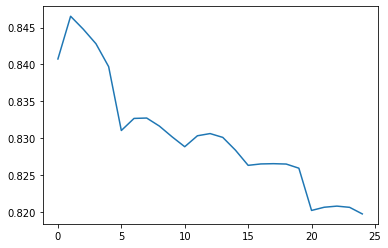

In [5]:
plt.plot(cvs)
plt.show()

In [ ]:
#temp = []
#for i in range(30):
#    if not i in [s * 5-1 for s in range(10)]:
#        temp.append(preds[i])
#preds2 = temp.copy()     

In [7]:
adj_cvs = [i - 0.5 for i in cvs]
weights = [i/sum(adj_cvs) for i in adj_cvs]
final_pred = np.zeros((200000,))
for pred in range(len(preds)):
    if preds[pred].shape == (200000,2):
        final_pred += weights[pred] * preds[pred][:,1]
    else:
        final_pred += weights[pred] * preds[pred]
        
final_pred

array([0.3048989 , 0.639223  , 0.07293235, ..., 0.35365551, 0.66508035,
       0.16567642])

In [10]:
temp = 0
for x,y in zip(final_pred, pd.read_csv('emb_lr_nn_xgb_cat_lgbm2.csv').target):
    temp += abs(x-y)/len(final_pred)
temp

0.030103151632998766

In [22]:

temps = []
for i in  tqdm(range(5)):
    for s in range(5):
        temp = 0
        for m in range(len(preds2[i])):
            temp += abs(preds2[i]-preds2[i])/len(preds2[i])
        temps.append(temp)
plt.plot(temps)
plt.show()





  0%|          | 0/5 [00:00<?, ?it/s]



 20%|██        | 1/5 [08:00<32:02, 480.66s/it]

KeyboardInterrupt: 

In [8]:
alt = pd.read_csv('emb_lr_nn_xgb_cat_lgbm.csv')
avg = 0
for x,y in zip(final_pred,alt.target):
    avg += abs(x-y)/len(final_pred)
avg

0.1170128372484102

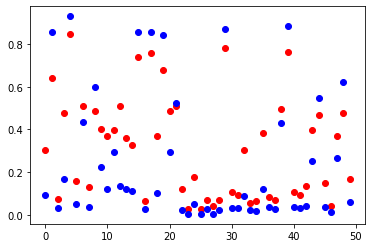

In [9]:
plt.plot(range(50), final_pred[:50],'ro')
plt.plot(range(50), alt.target[:50],'bo')

In [12]:
sub = pd.read_csv('input/sample_submission.csv')
sub['target'] = final_pred
sub.to_csv('emb_lr_nn_xgb_cat_lgbm3.csv',index=False)

In [11]:
max(np.load('embs/train_emb5.npy').reshape((-1,)))

18.229977